# Predict the tag for a Stack Overflow question


As a first example, you will download a dataset of programming questions from Stack Overflow. Each question ("How do I sort a dictionary by value?") is labeled with exactly one tag (Python, CSharp, JavaScript, or Java).

## Setup



In [1]:
import collections
import pathlib
import random
import re
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import tensorflow_datasets as tfds
import warnings
warnings.filterwarnings('ignore')

## Download and Explore the Dataset


In [2]:
data_url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset_dir = tf.keras.utils.get_file(origin = data_url,
                                       fname = 'stack_overflow_16k',
                                         untar = True,
                                         cache_dir = 'stack_overflow',
                                         cache_subdir = '')
dataset_dir = pathlib.Path(dataset_dir).parent

6053168/6053168 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
list(dataset_dir.iterdir())



[WindowsPath('/tmp/.keras/README.md'),
 WindowsPath('/tmp/.keras/stack_overflow_16k.tar.gz'),
 WindowsPath('/tmp/.keras/test'),
 WindowsPath('/tmp/.keras/train')]

In [4]:
train_dir = dataset_dir/'train'
list(train_dir.iterdir())


[WindowsPath('/tmp/.keras/train/csharp'),
 WindowsPath('/tmp/.keras/train/java'),
 WindowsPath('/tmp/.keras/train/javascript'),
 WindowsPath('/tmp/.keras/train/python')]

    The train/csharp, train/java, train/python and train/javascript directories contain many text files, each of which is a Stack Overflow question.

In [6]:
sample_file = train_dir/'python/1755.txt'

with open(sample_file, 'r') as f:
    print(f.read())


why does this blank program print true x=true.def stupid():.    x=false.stupid().print x



## Load the Dataset


In [7]:
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(train_dir,
                                                       batch_size = batch_size,
                                                         seed = seed,
                                                       validation_split = 0.2,
                                                       subset = 'training')
val_ds = tf.keras.utils.text_dataset_from_directory(train_dir,
                                                   batch_size = batch_size,
                                                   seed = seed,
                                                   validation_split = 0.2,
                                                   subset = 'validation')

for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print(text_batch.numpy()[i])
        print()
        print(label_batch.numpy()[i])

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen,

In [8]:
for i, label in enumerate(train_ds.class_names):
    print("Label", i, "corresponds to", label)


Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [9]:
test_dir = dataset_dir/'test'
test_ds = tf.keras.utils.text_dataset_from_directory(test_dir,
                                                    batch_size = batch_size)

Found 8000 files belonging to 4 classes.


## Configure the Dataset for Performance


In [10]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.experimental.AUTOTUNE)


## Prepare the Dataset for Training


- You will build two models to learn more about standardization, tokenization, and vectorization with TextVectorization:

        First, you will use the 'binary' vectorization mode to build a bag-of-words model.
        Then, you will use the 'int' mode with a 1D ConvNet

In [11]:
vocab_size = 10000

binary_vectorize_layer = layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = 'binary'
)

int_vectorize_layer = layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = 'int',
    output_sequence_length = 250
)

In [12]:
# Make a text-only dataset (without labels), then call `TextVectorization.adapt`.
train_text = train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

In [13]:
# Print the result of using these layers to preprocess data
# Retrieve a batch (of 32 reviews and labels) from the dataset.
text_batch, label_batch = next(iter(train_ds))
first_question, first_label = text_batch[0], label_batch[0]
print("Question:", first_question)
print("Label:", first_label)

Question: tf.Tensor(b'"blank8 why is my solution faster than the neat solution? (hackerrank chocolate feast) edit: simplified my solution..edit: removed opinion based secondary question...background: atarted learning blank a week or two ago using hackerranks problems as exercises and stackoverflow search + google as my teacher, i\'ve had some limited experience learning other languages...i did the exercise my own ""noobish learner way"" which i can\'t help but feel is a ""botched job"" when i see ""neat &amp; short"" solutions...however, when submitting both solutions one after another a couple of times i found the ""neat"" solution was quite a bit slower. ..i vaguely remember something about % operations being costly, is mine faster because of no % operations or is there more to it than just that?..exercise: https://www.hackerrank.com/challenges/chocolate-feast..neat solution from discussion:..import blank.io.*;.import blank.util.*;..public class solution {.    static int cc; .    pub

'binary' vectorized question: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 

(0.0, 1000.0)

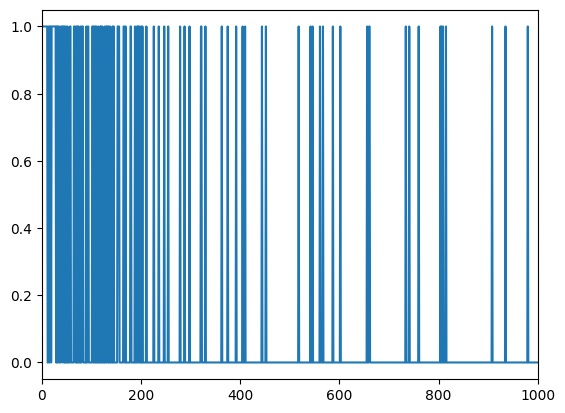

In [14]:
import matplotlib.pyplot as plt

print("'binary' vectorized question:",
      list(binary_vectorize_layer(first_question).numpy()))

plt.plot(binary_vectorize_layer(first_question).numpy())
plt.xlim(0,1000)

    The binary vectorization layer returns a multi-hot vector, with a 1 in the location for each token that was in the input string.

In [15]:
print("'int' vectorized question:",
      int_vectorize_layer(first_question).numpy())

'int' vectorized question: [   1  111    6   23  299 1787  198    2 3623  299 7826    1    1  805
 2568   23    1 1218 3892  364 4145    1    1  661   16    5  981   45
  121 1881   47    1  742   36 9987    8 1982  322  662   36   23 2362
  195  543   83 2693 2609  661  144    1  411    2 1371   23  657    1
 6520   84   66    3  166  104   26 1182    6    5    1 1639   44    3
  189 3623  519 1135    1   44 5468  280 1272   71  156  157    5 1759
    9  331    3  227    2 3623  299  115  810    5  547 3833    3    1
 2371  146  202 1195  289    1    6 2179 1787  193    9  136 1195   45
    6   67  181    4   11  198  106    1    1  299   31    1 2216 1924
   29  299   53   28 2081   22   53   42  170  154  256    7   15  453
   28    1  237 2698    1  134 2698  131 2698  323 2698    1    1    1
    1    1    1   23    1 2216 1924   29  299   22   53   42  170  154
  256 1360   15  453   28  237    1  237   68    9  196  807   28 7167
    1  237    1 1364    1  562    1 4406  735 1820

    As shown above, TextVectorization's 'binary' mode returns an array denoting which tokens exist at least once in the input, while the 'int' mode replaces each token by an integer, thus preserving their order.

## Model 1: Bag-of-words model


In [20]:
binary_model = tf.keras.Sequential([
    binary_vectorize_layer,
    layers.Dense(64, activation = 'relu'),
    layers.Dense(4)
])

binary_model.compile(optimizer = 'adam',
                     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                     metrics = ['accuracy'])

binary_history = binary_model.fit(train_ds,
                                  validation_data = val_ds,
                                  epochs = 10)

Epoch 1/10


200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.6042 - loss: 1.0239 - val_accuracy: 0.8338 - val_loss: 0.4958
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8794 - loss: 0.3798 - val_accuracy: 0.8388 - val_loss: 0.4485
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9467 - loss: 0.2082 - val_accuracy: 0.8363 - val_loss: 0.4616
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9756 - loss: 0.1201 - val_accuracy: 0.8319 - val_loss: 0.4928
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9898 - loss: 0.0709 - val_accuracy: 0.8269 - val_loss: 0.5319
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9965 - loss: 0.0424 - val_accuracy: 0.8213 - val_loss: 0.5755
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9972 - loss: 0.0269 - val_accuracy: 0.8163 - val_loss: 0.6243
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9998 - loss: 0.0183 - val_accuracy: 0.818

In [21]:
binary_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 10000)          │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │       640,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,920,974 (7.33 MB)

 Trainable params: 640,324 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,280,650 (4.89 MB)

## Model 2: 1D ConvNet


In [22]:
def create_int_model(vocab_size, num_labels, vectorizer = None):
    my_layers = []
    if vectorizer is not None:
        my_layers = [vectorizer]
    
    my_layers.extend([
        layers.Embedding(vocab_size, 64, mask_zero = True, name = 'embedding'),
        layers.Dropout(0.2),
        layers.Conv1D(64, 5, activation = 'relu', padding = 'valid', name = 'conv1d_1'),
        layers.GlobalMaxPooling1D(),
        layers.Dense(16, activation = 'relu'),
        layers.Dense(num_labels)
    ])
    model = tf.keras.Sequential(my_layers)
    return model

int_model = create_int_model(vocab_size, 4, int_vectorize_layer)
int_model.compile(optimizer = 'adam',
                  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                  metrics = ['accuracy'])

int_history = int_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 10)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.3289 - loss: 1.3158 - val_accuracy: 0.6406 - val_loss: 0.9016
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.6703 - loss: 0.8132 - val_accuracy: 0.7681 - val_loss: 0.5779
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.8313 - loss: 0.4706 - val_accuracy: 0.8056 - val_loss: 0.4889
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9123 - loss: 0.2822 - val_accuracy: 0.8188 - val_loss: 0.4790
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9615 - loss: 0.1611 - val_accuracy: 0.8231 - val_loss: 0.5177
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.9822 - loss: 0.0857 - val_accuracy: 0.8281 - val_loss: 0.5476
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9937 - loss: 0.0402 - val_accuracy: 0.8281 - val_loss: 0.5804
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.9984 - loss: 0.0207 - val_accu

In [23]:
int_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 250, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 250, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 246, 64)        │        20,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,984,958 (7.57 MB)

 Trainable params: 661,652 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,323,306 (5.05 MB)

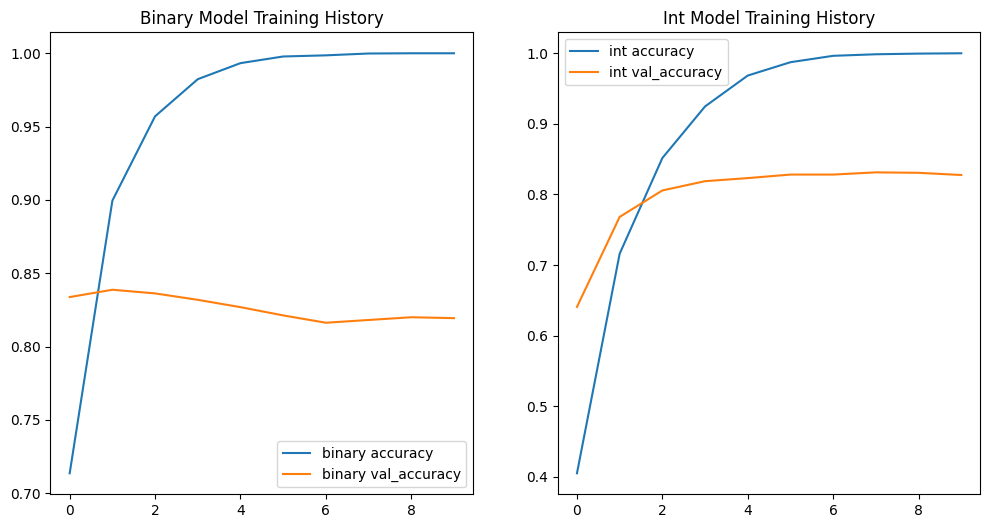

In [24]:
# compare the training history

fig, axs = plt.subplots(1, 2, figsize = (12, 6))

axs[0].plot(binary_history.history['accuracy'], label = 'binary accuracy')
axs[0].plot(binary_history.history['val_accuracy'], label = 'binary val_accuracy')
axs[0].set_title('Binary Model Training History')
axs[0].legend()

axs[1].plot(int_history.history['accuracy'], label = 'int accuracy')
axs[1].plot(int_history.history['val_accuracy'], label = 'int val_accuracy')
axs[1].set_title('Int Model Training History')
axs[1].legend()

plt.show()


In [30]:
# Convert the input list to a tensor
input_text = tf.constant(['How do I sort a dictionary by value?'])

# Use the model to predict
prediction = binary_model.predict(input_text)
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
[[ 0.5779748  -1.7754048  -1.6220104   0.90607095]]


In [31]:
tf.argmax(prediction, axis = 1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([3], dtype=int64)>

    Label 3 corresponds to python
